# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
%%javascript

IPython.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : "run cell and keep focus", //This is optional
    handler : function (event) {
        IPython.notebook.execute_cell();
        IPython.notebook.edit_mode();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transform

from torch.utils.serialization import load_lua
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
# from models import build_ssd as build_ssd_v1 # uncomment for older pool6 model

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [4]:
net_primed = build_ssd('test', 300, controller_bias=False, controller_sigmoid=False,  # initialize SSD
                        insertBNLayers=False, residual_controllers=True,add_relu=False,
                    add_hint_interpreter = False)

H='1100'
#oldNetDict = torch.load('/home/amir/ssd.pytorch/weights/ssd300_mAP_77.43_v2.pth')
if H=='1100':
    oldNetDict = torch.load('/home/amir/1100/ssd300_0712_7000.pth')
elif H=='1110':
    oldNetDict = torch.load('/home/amir/1100/ssd300_0712_5000.pth')
#oldNetDict = torch.load('/home/amir/1111/ssd300_0712_8000.pth')
elif H=='1000':
    oldNetDict = torch.load('/home/amir/1000/ssd300_0712_6000.pth')
#oldNetDict = torch.load('/home/amir/1110/ssd300_0712_10000.pth')

new_net_dict = net_primed.state_dict ()
for k in oldNetDict.keys():
    if k in new_net_dict:
        new_net_dict[k] = oldNetDict[k]
net_primed.load_state_dict(new_net_dict)
net = build_ssd('test', 300, controller_bias=False, controller_sigmoid=False,  # initialize SSD
                        insertBNLayers=False, residual_controllers=True,add_relu=False,
                    add_hint_interpreter = False)

oldNetDict = torch.load('/home/amir/Downloads/ssd300_mAP_77.43_v2.pth')
#oldNetDict = torch.load('/home/amir/1100/ssd300_0712_5000.pth')
new_net_dict = net.state_dict ()
for k in oldNetDict.keys():
    if k in new_net_dict:
        new_net_dict[k] = oldNetDict[k]
net.load_state_dict(new_net_dict)

## Load Image 
### Here we just load a sample image from the VOC07 dataset 

In [5]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
#%matplotlib inline

#%pylab inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOCroot, AnnotationTransform, BaseTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
VOCroot = '/home/amir/voc/VOCdevkit/'
dataset_mean = (104, 117, 123)
testset = VOCDetection(VOCroot, [('2007', 'test2')], BaseTransform(300, dataset_mean), AnnotationTransform())
 
# View the sampled input image before transform
#plt.figure(figsize=(10,10))
#plt.imshow(rgb_image)
#plt.show()

In [6]:
from data import VOC_CLASSES as labels
label_to_ind = dict([(k,i) for i,k in enumerate(labels)])    
def to_n(im):
    im_n = im.numpy().transpose(1,2,0)    
    im_n = im_n-im_n.min()
    im_n = im_n/im_n.max()
    return im_n

In [7]:
def makeHint(gt):
    hints = 0 * torch.ones(1,20)
    hints[0,int(gt[0,-1])]= 1
    hints = Variable(hints)*1
    hints = hints.cuda();
    return hints

def showDetections(rgb_image,detections,myThresh=.6,required_label='',toPrint=False,toShowImage=True,color='red',curAxis=None,
                  top_k=2):
    detections = detections.data
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    if toShowImage:
        plt.imshow(rgb_image)  # plot the image for matplotlib
    if curAxis is None:
        currentAxis = plt.gca()    
    else:
        currentAxis = curAxis
    # scale each detection back up to the image
    kk=0
    scale = torch.Tensor([rgb_image.shape[1::-1], rgb_image.shape[1::-1]])    
    for i in range(detections.size(1)):
    #for i in range(min(detections.size(1),top_k)):
        #if i-1!=label_to_ind['horse']:
        #    continue
        j = 0
        while detections[0,i,j,0] >= myThresh :
            kk+=1
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            if len(required_label)==0 or label_name==required_label:
                if toPrint:
                    print(round(score*1000)/1000,label_name,end="|")
                display_txt = '%s: %.2f'%(label_name, score)
                pt = (detections[0,i,j,1:]*scale).cpu().numpy()
                coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
                #color = color
                theWidth=2
                if color=='red':
                    theStyle='dashed'
                    theWidth=2
                else:
                    theStyle=':'
                    theWidth=4
                currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color,linewidth=theWidth, linestyle=theStyle))
                #currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            if kk >= top_k:
                break
            j+=1
        if kk >= top_k:
                break
    return currentAxis
def postHint(y,gt):
    for q in range(21):
        if q != gt+1:        
            y[:,q,:,0]=-10
def addNoiseToImage(image,myNoise,toClip=False):
    image+=myNoise
    if toClip:
        image[image<-128]=-128
        image[image>128]=128
    return image    
ind_to_label = {}
for k,v in label_to_ind.items():
    ind_to_label[v]=k

In [8]:
def getImageAndStuff(testset,item_id,addTheNoise,toClip):
    image, gt_and_box, h, w = testset.pull_item(item_id)
    gt = int(gt_and_box[0,-1])
    image = addNoiseToImage(image,myNoise,toClip=toClip)
    rgb_image = to_n(image.cpu())
    image = Variable(image.cuda().unsqueeze(0))
    
    return image,gt_and_box,h,w,gt,rgb_image
def makeHints(gt):
    hints = torch.zeros(1,20)
    hints[0,gt]= 1
    hints = Variable(hints.cuda())
    return hints

In [9]:
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from matplotlib.pyplot import  gcf,axis

#noises = [0,15,30,45,70,85,100]
noises = [0,25,50,100]#[0,15,30,45,100]
thresholds = [.5, .2, .1,.01]
nn = len(noises)
nt = len(thresholds)
#item_id = 237
items_ids = [0];#range(0,1000,10)


In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))

In [22]:
import seaborn
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

items_ids = range(0,200,1)
for toClip in [False]:
    for item_id in [p for p in items_ids]:
        outPath = '/home/amir/publications/priming/{}/_clip_{}_H_{}.pdf'.format(H,item_id,toClip)
        #if os.path.isfile('/home/amir/publications/priming/{}.jpg'.format(item_id)):
        #    continue
        print (item_id)
        #plt.close()
        fig = plt.figure(figsize = (10,10))
        
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(nn, nt),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )        
        #gs1 = gridspec.GridSpec(nn,nt,height_ratios=[0.5]*nn,width_ratios=[1]*nt,
        #         wspace=0.0, hspace=0.0, bottom=0.05, left=0, right=.2)#0.845)            
        use_hint=True
        for i,noise in enumerate(noises):            
            myNoise = (torch.randn(1,3,300,300)*noise).cpu()
            for j,th in enumerate(thresholds):                
                image,gt_and_box,h,w,gt,rgb_image = getImageAndStuff(testset,item_id,myNoise,toClip)
                required_label=''       
                y = net(image,None,hint_override_vgg = None, extra_ovr = None,
                                loc_ovr = None, conf_ovr = None)
                postHint(y,gt)
                vv = i*nt+j             
                plt.axis('on')
                #ax = plt.subplot(gs1[vv])
                ax = grid[vv]
                for sp in ax.spines.values():
                    sp.set_visible(False)
                ax.axis["right"].set_visible(False)
                ax.axis["top"].set_visible(False)
                ax.axis["bottom"].set_visible(False)
                #ax.axis["left"].set_visible(False)
                ax.set_aspect('equal')
                ax.set_xticklabels([]);ax.set_yticklabels([])
                plt.sca(ax)
                if i == 0:
                    plt.title('thresh='+str(th))
                if j==0:
                    plt.ylabel('$\sigma='+str(noise)+'$')
                
                
                hints=makeHints(gt)                
                y_primed = net_primed(image,hints,hint_override_vgg = H[0]=='1', extra_ovr = H[1]=='1',
                                loc_ovr = H[2]=='1', conf_ovr = H[3]=='1')
                postHint(y_primed,gt)
                curAxis = showDetections(rgb_image,y_primed,th,required_label,toShowImage=False,color='blue')
                showDetections(rgb_image,y,th,required_label,toShowImage=True,color='red',curAxis=curAxis)
                
                
                #axis('off')
        #plt.subplots_adjust(wspace=0, hspace=0)

        #for ax in axes.ravel():
        #    ax.axis('off')
        plt.tight_layout()
        #all_axes = gcf().get_axes()
        #for ax in all_axes:
        #    for sp in ax.spines.values():
        #        sp.set_visible(False)
        #plt.show()
        #plt.show()
        plt.savefig(outPath,bbox_inches='tight')
        
    


0


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

1


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

2


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

3


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

4


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

5


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

6


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

7


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

8


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

9


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

10


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

11


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

12


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

13


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

14


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

15


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

16


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

17


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

18


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

19


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

20


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

21


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

22


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

23


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

24


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

25


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

26


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

27


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

28


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

29


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

30


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

31


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

32


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

33


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

34


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

35


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

36


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

37


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

38


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

39


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

40


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

41


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

42


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

43


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

44


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

45


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

46


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

47


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

48


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

49


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

50


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

51


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

52


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

53


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

54


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

55


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

56


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

57


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

58


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

59


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

60


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

61


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

62


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

63


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

64


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

65


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

66


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

67


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

68


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

69


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

70


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

71


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

72


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

73


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

74


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

75


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

76


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

77


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

78


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

79


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

80


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

81


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

82


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

83


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

84


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

85


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

86


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

87


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

88


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

89


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

90


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

91


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

92


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

93


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

94


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

95


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

96


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

97


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

98


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

99


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

100


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

101


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

102


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

103


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

104


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

105


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

106


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

107


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

108


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

109


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

110


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

111


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

112


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

113


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

114


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

115


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

116


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

117


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

118


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

119


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

120


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

121


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

122


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

123


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

124


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

125


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

126


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

127


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

128


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

129


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

130


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

131


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

132


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

133


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

134


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

135


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

136


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

137


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

138


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

139


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

140


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

141


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

142


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

143


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

144


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

145


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

146


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

147


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

148


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

149


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

150


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

151


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

152


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

153


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

154


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

155


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

156


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

157


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

158


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

159


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

160


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

161


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

162


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

163


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

164


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

165


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

166


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

167


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

168


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

169


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

170


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

171


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

172


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

173


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

174


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

175


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

176


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

177


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

178


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

179


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

180


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

181


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

182


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

183


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

184


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

185


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

186


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

187


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

188


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

189


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

190


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

191


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

192


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

193


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

194


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

195


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

196


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

197


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

198


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

199


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that 

In [164]:
ax.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x7f921037f128>),
             ('right', <matplotlib.spines.Spine at 0x7f921037f470>),
             ('bottom', <matplotlib.spines.Spine at 0x7f921037f978>),
             ('top', <matplotlib.spines.Spine at 0x7f921037f860>)])

In [52]:

#y1[np.argsort(-y1)]

array([ 99, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 126, 148, 125, 123,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 124, 101, 149, 151, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 176, 150, 175, 173, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 174, 100, 199,  98,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  25,  47,  24,  22,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  23,  48,  49,  50,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  76,  75,  74,  73,  51,  52,  53,  54,  5

In [33]:
y.size()

torch.Size([1, 21, 200, 5])

In [25]:
#y[:,gt+1,:][0]

Variable containing:
 0.0168 -0.0013  0.0967  0.9996  0.8624
 0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000
                   ⋮                    
 0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 200x5 (GPU 0)]

2


/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)
/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)


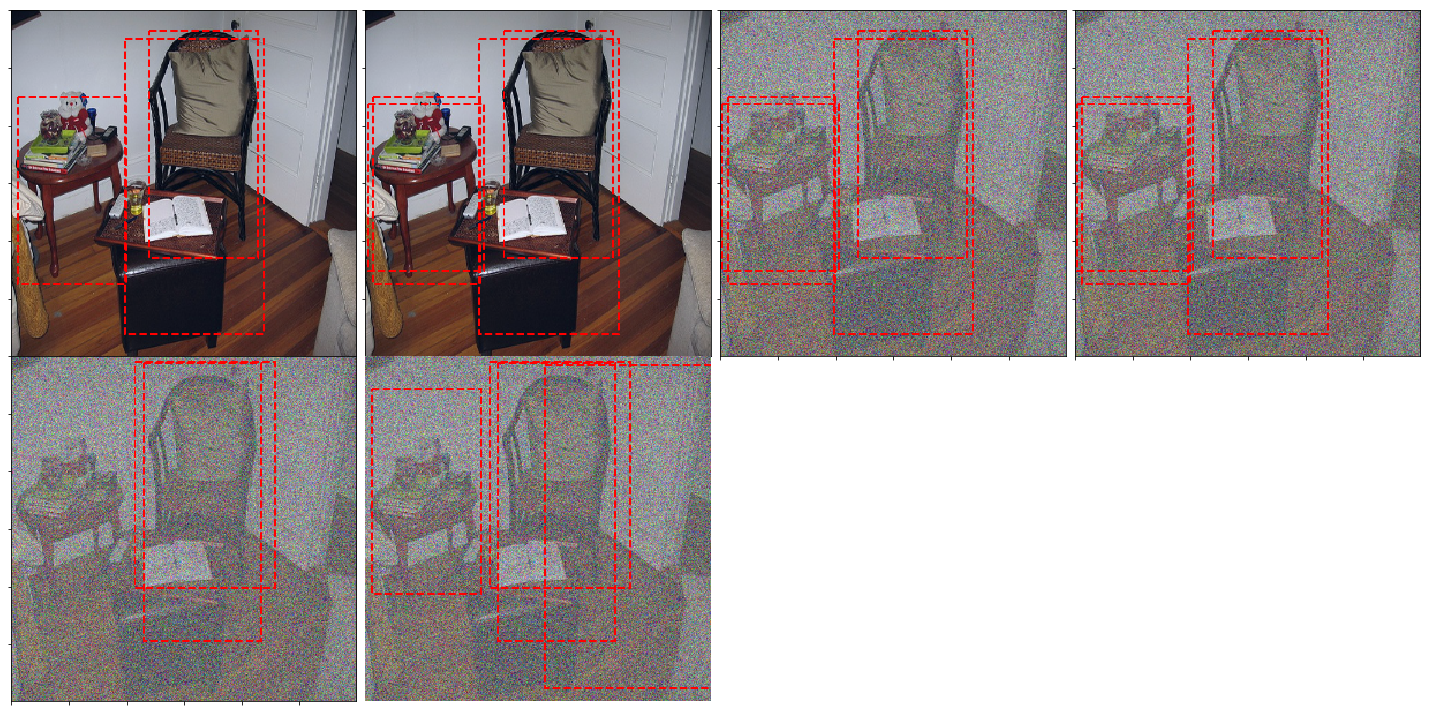

In [174]:
#%pylab inline
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from matplotlib.pyplot import  gcf,axis

#noises = [0,15,30,45,70,85,100]
noises = [0,100]#[0,15,30,45,100]
thresholds = [.5, .2, .1,.01]
nn = len(noises)
nt = len(thresholds)
#item_id = 237
items_ids = [2];#range(0,1000,10)
for toClip in [False]:
    for item_id in [p for p in items_ids]:
        outPath = '/home/amir/publications/priming/1000_{}_clip_{}_H_{}.jpg'.format(item_id,toClip,H)
        #if os.path.isfile('/home/amir/publications/priming/{}.jpg'.format(item_id)):
        #    continue
        print (item_id)
        plt.close()
        plt.figure(figsize=(5,5))
        #gs1 = gridspec.GridSpec(nn,nt,height_ratios=[1]*nn,width_ratios=[1]*len(thresholds),
        #         wspace=0.0, hspace=0.0)#, bottom=0.05, left=0, right=.4)#0.845)    
        f = gcf()
        f.set_figheight(10)
        f.set_figwidth(20)
        use_hint=True
        for i,noise in enumerate(noises):
            to_add_noise = noise
            myNoise = (torch.randn(1,3,300,300)*to_add_noise).cpu()

            for j,th in enumerate(thresholds):
                #if to_add_noise==0:                    
                #print()
                #print('############'   ,noise,th,'    ######')

                image, gt_and_box, h, w = testset.pull_item(item_id)
                gt = int(gt_and_box[0,-1])
                image = addNoiseToImage(image,myNoise,toClip=toClip)
                rgb_image = to_n(image.cpu())
                image = Variable(image.cuda().unsqueeze(0))

                required_label=''       

                myThresh=th
                y = net(image,None,hint_override_vgg = None, extra_ovr = None,
                                loc_ovr = None, conf_ovr = None)
                postHint(y,gt)

                vv = i*nn+j
                #print('Y--------',vv,'---')
                #plt.sca(axes[i*2,j])
                plt.axis('on')
                ax = plt.subplot(gs1[vv])
                ax.set_aspect('equal')
                ax.set_xticklabels([])
                ax.set_yticklabels([])        
                #plt.sca(ax)

                showDetections(rgb_image,y,myThresh,required_label)
                axis('off')
                #print('\n--------------')

                hints = torch.zeros(1,20)
                hints[0,gt]= 1
                hints = Variable(hints)
                hints = hints.cuda();

                image, gt_and_box, h, w = testset.pull_item(item_id)
                gt = int(gt_and_box[0,-1])
                image = addNoiseToImage(image,myNoise,toClip=toClip)
                image = Variable(image.cuda().unsqueeze(0))
                y_primed = net_primed(image,hints,hint_override_vgg = H[0]=='1', extra_ovr = H[1]=='1',
                                loc_ovr = H[2]=='1', conf_ovr = H[3]=='1')
                postHint(y_primed,gt)
                #plt.sca(axes[i*2+1,j])
                vv = (i*2+1)*nn+j
                #print('Y_PRIME----',vv,'---')
                #plt.axis('on')
                #ax =plt.subplot(gs1[vv])
                #ax.set_aspect('equal')
                #ax.set_xticklabels([])
                #ax.set_yticklabels([])

                #plt.sca(ax)

                showDetections(rgb_image,y_primed,myThresh,required_label)
                axis('off')
        #plt.subplots_adjust(wspace=0, hspace=0)

        #for ax in axes.ravel():
        #    ax.axis('off')
        plt.tight_layout()
        plt.show()
        #plt.savefig(outPath)
                                        

In [8]:
# create external gt by using the default detector.
import glob
files=glob.glob('/home/amir/voc/VOCdevkit/VOC2007/results/*.txt')
files.sort(key=os.path.getmtime)
#print("\n".join(files))

f = files[-20:]

In [9]:
f

['/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_aeroplanec08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_bicyclec08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_birdc08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_boatc08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_bottlec08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_busc08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_carc08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_catc08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_chairc08fa40a-17a2-4bb7-bd17-16e5751492ae.txt',
 '/home/amir/voc/VOCdevkit/VOC2007/results/det_test2_cowc08fa40a-17a2-4bb7-bd17-16e5751492ae

In [10]:
labels = label_to_ind.keys()

In [11]:
# for each file, list all detections. retain detection with maximal score.

files_to_dets = {}

all_detections = []

for ff in f:
    p = open(ff).readlines()
    curLabel = ''
    for l in labels:
        if l in ff:
            curLabel=l
            break
    assert curLabel!=''
    for pp in p:
        pp = pp.strip().split()
        all_detections.append(dict(label=curLabel,image_id=pp[0],score=float(pp[1])))

In [12]:
z

NameError: name 'z' is not defined

In [ ]:
ids = open('/home/amir/voc/VOCdevkit/VOC2007/ImageSets/Main/test2.txt').readlines()
ids = [s.strip() for s in ids]


In [ ]:
import pandas as pd
df = pd.DataFrame(all_detections)
df2=df.loc[list(df.groupby(['image_id']).idxmax()['score'])]
gts = [label_to_ind[k] for k in df2.set_index('image_id').label.tolist()]
open('/home/amir/external_gt.txt','w').writelines([str(q)+'\n' for q in gts])

In [ ]:
import pickle
p=pickle.load(open('/home/amir/Downloads/aeroplane_pr.pkl'))

In [ ]:
image = torch.zeros()

In [257]:
import glob
g = glob.glob('/home/amir/noclip/*')
z = []
for gg in g:
    #break
    x=gg.split('/')[-1].split('_')
    if '#' in gg:
        H='0000'
        iteration=0
        level_of_noise=x[-6].split('.')[0][2:]
    #else:
        #break
    else:
        H,level_of_noise,iteration=x[1],int(x[-8].split('.')[0]),int(x[-10])
    perf = float(open(gg).readlines()[-7].strip())
    z.append(dict(H=H,noise=level_of_noise,iteration=iteration,perf=perf))
    
import pandas as pd
import seaborn as sns
df=pd.DataFrame(z)

plt.close()
sns.factorplot(data=df,aspect=2,x = 'iteration',y='perf')
plt.show()

0.722

In [261]:
df

,H,iteration,noise,perf
0,1111,8000,10,0.815
1,1111,8000,80,0.264
2,1000,10000,0,0.846
3,1000,10000,120,0.180
4,1110,8000,60,0.458
5,1100,7000,120,0.189
6,1100,7000,100,0.231
7,1111,8000,100,0.181
8,1100,7000,130,0.173
9,1000,10000,100,0.204


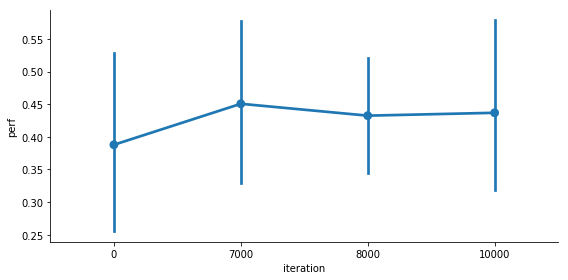